In [2]:

import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_excel(r'C:\Users\raviv\Downloads\Adjusted-Historical-Prices-NSE.xlsx',header=2)


C:\Users\raviv\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
df

,PriceDate,OpenPrice,Highprice,lowprice,closeprice,tradedvalue,Numberoftrades,TradedQuantity,AveragePrice
0,02/05/2014,867.3000,873.3333,840.0333,842.3667,2.408006e+09,80981,2832488,850.1382
1,05/05/2014,842.7333,863.3333,834.1333,855.9667,1.871180e+09,57493,2194436,852.6927
2,06/05/2014,861.0333,869.8000,859.2667,866.6667,1.716827e+09,42173,1984607,865.0717
3,07/05/2014,865.1333,875.3333,859.3667,863.7333,1.996398e+09,55984,2302158,867.1854
4,08/05/2014,868.3333,871.8667,850.6667,866.1000,2.833874e+09,68693,3285168,862.6268
...,...,...,...,...,...,...,...,...,...
2504,14/06/2024,3718.0000,3720.0000,3675.0000,3687.8000,6.444028e+09,116358,1746508,3689.6639
2505,18/06/2024,3708.0000,3710.0000,3675.0000,3689.2000,7.155863e+09,125205,1936792,3694.6989
2506,19/06/2024,3690.0000,3699.0000,3575.0000,3589.9500,1.063733e+10,174218,2936151,3622.8809
2507,20/06/2024,3584.9500,3613.3000,3564.6000,3594.4500,9.394746e+09,168275,2618715,3587.5406


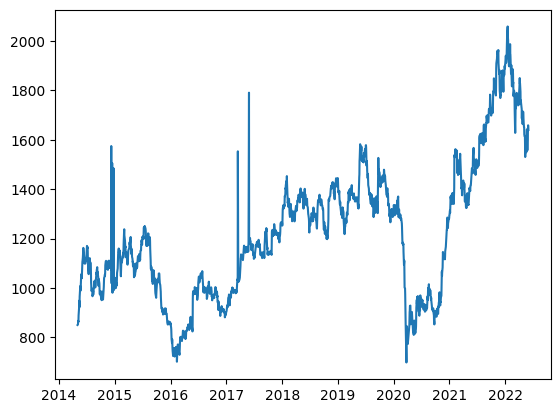

In [4]:
df['PriceDate'] = pd.to_datetime(df['PriceDate'],format='%d/%m/%Y')
timeseries = df[["AveragePrice"]].values.astype('float32')
 
plt.plot(df['PriceDate'][:2000],timeseries[:2000])
plt.show()

In [5]:
from sklearn.preprocessing import StandardScaler

# Assuming 'timeseries' is your original time series data

# Calculate sizes for train, test, and validation sets
train_size = int(len(timeseries) * 0.7)
test_size = int(len(timeseries) * 0.15)
validation_size = int(len(timeseries) * 0.15)

# Split the data
train_data = timeseries[:train_size]
temp_data = timeseries[train_size:]

test_data = temp_data
validation_data = temp_data[:test_size]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
total_data_scaled = scaler.fit_transform(timeseries.reshape(-1, 1)).flatten()
train_data_scaled = scaler.transform(train_data.reshape(-1, 1)).flatten()

# Transform the test and validation data using the scaler fitted on the training data
test_data_scaled = scaler.transform(test_data.reshape(-1, 1)).flatten()
validation_data_scaled = scaler.transform(validation_data.reshape(-1, 1)).flatten()

# Now train_data_scaled, test_data_scaled, and validation_data_scaled
# contain your scaled data


In [7]:
########
import torch
from torch.utils.data import Dataset,DataLoader
class Dataset:
    """Transform a time series into a prediction dataset
    
    Args:
        feature: A numpy array of time series, first dimension is the time steps
        sequence_length: Size of window for prediction
    """
    def __init__(self, feature, sequence_length):
        self.feature = feature
        self.sequence_length = sequence_length
    
    def __len__(self):
        return len(self.feature) - self.sequence_length
    
    def __getitem__(self, idx):
        idx_end = idx + self.sequence_length
        feature = self.feature[idx:idx_end]
        label = self.feature[idx_end]
        
        return torch.tensor(feature),torch.tensor(label)


In [8]:
sequence_length=20
total_dataset=Dataset(total_data_scaled,sequence_length)
train_dataset=Dataset(train_data_scaled,sequence_length)
test_dataset= Dataset(test_data_scaled, sequence_length)
val_dataset= Dataset(validation_data_scaled, sequence_length)


In [9]:
total_loader=DataLoader(total_dataset,batch_size=4,shuffle=False)
train_loader=DataLoader(train_dataset,batch_size=4,shuffle=False)
test_loader=DataLoader(test_dataset,batch_size=4,shuffle=False)
val_loader=DataLoader(val_dataset,batch_size=4,shuffle=False)

In [10]:
###############################
from torch import nn
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Basic RNN layer, without dropout
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.tanh = nn.Tanh()  # Tanh activation layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden state*/
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # RNN output

        out, _ = self.rnn(x, h0)
        # Apply Tanh to the outputs of the RNN layer
        out = self.tanh(out)
        # Get the last sequence output accorss all batches
        out = out[:, -1, :]
        # Apply the linear layer for the final output
        out = self.fc(out)
        return out

In [11]:
from torch import optim
model = RNN(input_size=1, hidden_size=64, output_size=1, num_layers=2)
optimizer = optim.Adam(model.parameters(),lr=0.0001)
criterion = nn.MSELoss()


In [15]:
train_epoch_loss = []
val_epoch_loss = []
val_metrics = []
epochs = 20
import  numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm

for epoch in range(1, epochs + 1):
    total_train_loss = 0.0
    total_val_loss = 0.0
    predictions = []
    targets = []
    
    # Training loop
    model.train()
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs)
        loss = criterion(outputs,labels.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * inputs.size(0)
        
    train_epoch_loss.append(total_train_loss / len(train_loader.dataset))
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs = inputs.unsqueeze(-1)
            outputs = model(inputs)
        
            loss = criterion(outputs,labels.unsqueeze(-1))
            total_val_loss += loss.item() * inputs.size(0)
            predictions.extend(outputs.cpu().detach().numpy())
            targets.extend(labels.cpu().detach().numpy())
        
    val_epoch_loss.append(total_val_loss / len(val_loader.dataset))
    
    # Calculate validation metrics (e.g., MAE, RMSE)
    predictions = np.array(predictions)
    targets = np.array(targets)
    mse=mean_squared_error(predictions,targets)
    
    print(f"Epoch {epoch}/{epochs}, Train Loss: {train_epoch_loss[-1]}, Val Loss: {val_epoch_loss[-1]}, mse: {mse}")


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 848.17it/s]


Epoch 1/20, Train Loss: 0.0042501751530948624, Val Loss: 0.012641498170207056, mse: 0.012641497887670994


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 950.84it/s]


Epoch 2/20, Train Loss: 0.004257575789003991, Val Loss: 0.012171042721235883, mse: 0.012171043083071709


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 873.77it/s]


Epoch 3/20, Train Loss: 0.004241599207283974, Val Loss: 0.011874317160475309, mse: 0.011874317191541195


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 876.52it/s]


Epoch 4/20, Train Loss: 0.00423373175637884, Val Loss: 0.011574986669217927, mse: 0.011574986390769482


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 859.09it/s]


Epoch 5/20, Train Loss: 0.004227383702594791, Val Loss: 0.011234372553057195, mse: 0.011234371922910213


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 926.39it/s]


Epoch 6/20, Train Loss: 0.004220787823759636, Val Loss: 0.010826911950899874, mse: 0.010826912708580494


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 908.71it/s]


Epoch 7/20, Train Loss: 0.004213522122693236, Val Loss: 0.010333195395585871, mse: 0.010333195328712463


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 899.75it/s]


Epoch 8/20, Train Loss: 0.004205477293229211, Val Loss: 0.009756979586496383, mse: 0.00975697860121727


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 928.36it/s]


Epoch 9/20, Train Loss: 0.004196644211285279, Val Loss: 0.009156731248858092, mse: 0.009156730957329273


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 920.08it/s]


Epoch 10/20, Train Loss: 0.004187176318309825, Val Loss: 0.008616543430383736, mse: 0.008616543374955654


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 739.65it/s]


Epoch 11/20, Train Loss: 0.0041765952880063375, Val Loss: 0.008161572735884824, mse: 0.008161572739481926


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 875.05it/s]


Epoch 12/20, Train Loss: 0.004165632876167097, Val Loss: 0.007816454860659086, mse: 0.007816455326974392


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 858.66it/s]


Epoch 13/20, Train Loss: 0.004154413802538211, Val Loss: 0.007528031495853662, mse: 0.007528031710535288


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 924.91it/s]


Epoch 14/20, Train Loss: 0.004143379582898557, Val Loss: 0.007311050939616313, mse: 0.007311050780117512


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 949.38it/s]


Epoch 15/20, Train Loss: 0.00413225119032994, Val Loss: 0.007123373507710404, mse: 0.007123373914510012


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 989.25it/s]


Epoch 16/20, Train Loss: 0.00412155805618312, Val Loss: 0.006969947664504034, mse: 0.0069699473679065704


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 932.16it/s]


Epoch 17/20, Train Loss: 0.004110542478997035, Val Loss: 0.006828831879257256, mse: 0.006828831974416971


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 869.08it/s]


Epoch 18/20, Train Loss: 0.004099861662111813, Val Loss: 0.006707938449222495, mse: 0.006707938853651285


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 913.32it/s]


Epoch 19/20, Train Loss: 0.004088784099911183, Val Loss: 0.006591984943298393, mse: 0.006591985002160072


100%|█████████████████████████████████████████████████████████████████████████████████| 89/89 [00:00<00:00, 860.99it/s]

Epoch 20/20, Train Loss: 0.004077901945765497, Val Loss: 0.006487075175816623, mse: 0.0064870757050812244


100%|███████████████████████████████████████████████████████████████████████████████| 184/184 [00:00<00:00, 930.11it/s]


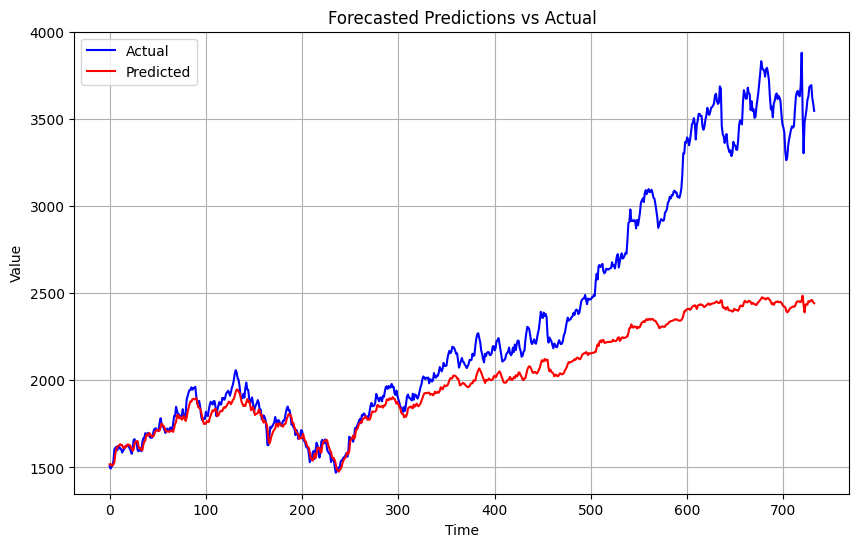

In [18]:
predictions = []
targets = []
model.eval()
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.unsqueeze(-1)
        outputs = model(inputs)

        loss = criterion(outputs,labels.unsqueeze(-1))
        total_val_loss += loss.item() * inputs.size(0)
        predictions.extend(outputs.cpu().detach().numpy())
        targets.extend(labels.cpu().detach().numpy())


predictions =scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
                       
                       
targets =scaler.inverse_transform(np.array(targets).reshape(-1, 1))

# Plotting forecasted predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(targets, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red')
plt.title('Forecasted Predictions vs Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()